# Cross-resource comparison of compounds in patents
This notebook has the distribution of patented compounds across three major chemical resources namely PubChem, ChEMBL, and DrugBank data resources.

The files used below were downloaded from the [FTP servers](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/) of PubChem.

# Import Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from upsetplot import plot

sns.set_style("whitegrid")

pd.options.mode.chained_assignment = None  # default='warn'

# Add path constants

In [2]:
FIG_DIR = "../data/figures"
DATA_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"
os.makedirs(FIG_DIR, exist_ok=True)

# Load data file

In [3]:
# SureChEMBL
surechem_df = pd.read_parquet(f"{DATA_DIR}/surechembl_dump.pq")
surechem_df.drop_duplicates(subset=["InChIKey"], inplace=True)
surechem_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description
1757,SCHEMBL9,O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...,OYFJQPXVCSSHAI-QFPUQLAESA-N,EP-2838373-A2,2015-02-25,Description


In [4]:
surechembl_cpds = set(surechem_df["InChIKey"].unique().tolist())
len(surechembl_cpds)

10686744

In [5]:
# PubChem
pubchem_df = pd.read_parquet(f"{PROCESSED_DIR}/surechembl_pubchem_map.pq.gzip")
pubchem_df = pubchem_df[pubchem_df["inchikey"].isin(surechembl_cpds)]
pubchem_df.head(2)

,cid,inchi,inchikey
0,1,InChI=1S/C9H17NO4/c1-7(11)14-8(5-9(12)13)6-10(...,RDHQFKQIGNGIED-UHFFFAOYSA-N
1,2,InChI=1S/C9H17NO4/c1-7(11)14-8(5-9(12)13)6-10(...,RDHQFKQIGNGIED-UHFFFAOYSA-O


In [6]:
# ChEMBL
chembl_df = pd.read_parquet(f"{PROCESSED_DIR}/chembl.pq.gzip")
chembl_df = chembl_df[chembl_df["inchikey"].isin(surechembl_cpds)]
chembl_df.head(2)

,chembl_id,clinical_phase,inchikey
12,CHEMBL6206,NaN,BYUCSFWXCMTYOI-ZRDIBKRKSA-N
24,CHEMBL6354,NaN,CKEYKKQODPYQPS-UHFFFAOYSA-P


In [7]:
drugbank_df = pd.read_csv(f"{DATA_DIR}/drugbank_approved_structure_links.csv.zip")
drugbank_df = drugbank_df[drugbank_df["InChIKey"].isin(surechembl_cpds)]
drugbank_df.head(2)

,DrugBank ID,Name,CAS Number,Drug Groups,InChIKey,InChI,SMILES,Formula,KEGG Compound ID,KEGG Drug ID,PubChem Compound ID,PubChem Substance ID,ChEBI ID,ChEMBL ID,HET ID,ChemSpider ID,BindingDB ID
0,DB00006,Bivalirudin,128270-60-0,approved; investigational,OIRCOABEOLEUMC-GEJPAHFPSA-N,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,C98H138N24O33,NaN,D03136,16129704.0,46507415.0,59173.0,CHEMBL2103749,NaN,10482069.0,50248103.0
1,DB00007,Leuprolide,53714-56-0,approved; investigational,GFIJNRVAKGFPGQ-LIJARHBVSA-N,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,C59H84N16O12,C07612,D08113,NaN,46507635.0,6427.0,CHEMBL1201199,NaN,571356.0,50369395.0


# Get unique compounds

In [8]:
# Pubchem
pubchem_cpds = set(pubchem_df["inchikey"].tolist())
chembl_cpds = set(chembl_df["inchikey"].tolist())
drugbank_cpds = set(drugbank_df["InChIKey"].tolist())

print(f"PubChem: {len(pubchem_cpds)}")
print(f"ChEMBL: {len(chembl_cpds)}")
print(f"DrugBank: {len(drugbank_cpds)}")

PubChem: 10089885
ChEMBL: 318139
DrugBank: 2096


# Visualisation

In [9]:
set_names = ["SureChEMBL", "ChEMBL", "PubChem", "DrugBank"]
all_elems = surechembl_cpds.union(chembl_cpds, pubchem_cpds, drugbank_cpds)
df = pd.DataFrame(
    [
        [e in surechembl_cpds, e in chembl_cpds, e in pubchem_cpds, e in drugbank_cpds]
        for e in all_elems
    ],
    columns=set_names,
)
df_up = df.groupby(set_names).size()

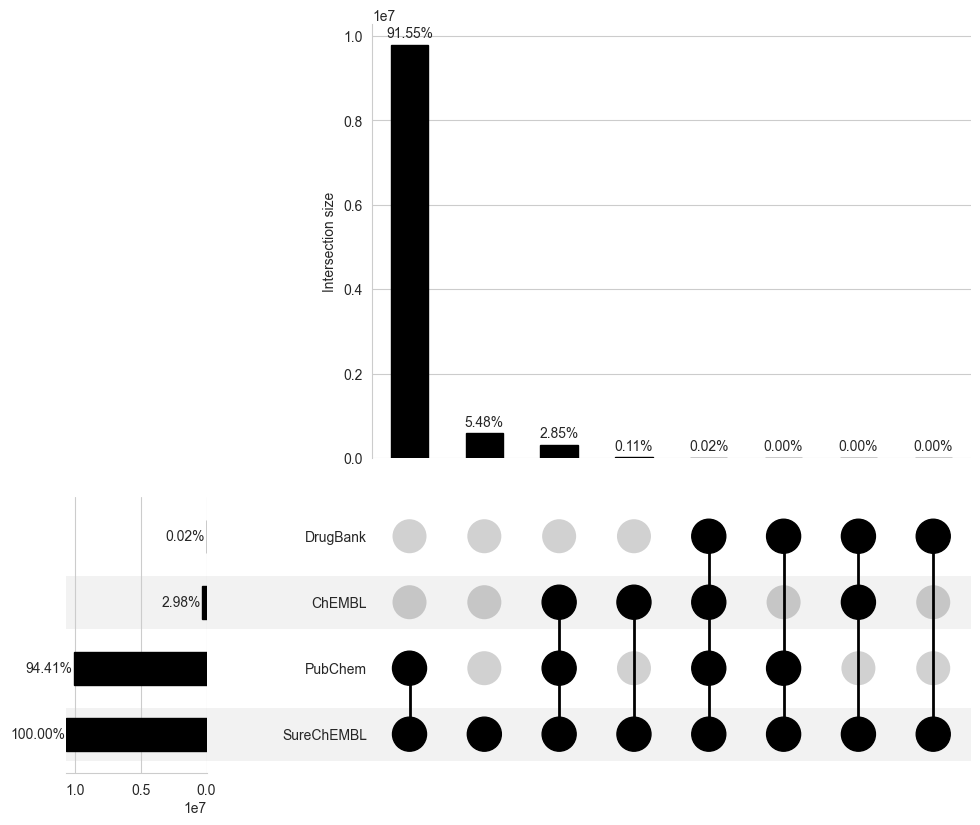

In [10]:
fig = plt.figure(figsize=(10, 5))
plot(
    df_up,
    orientation="horizontal",
    show_percentages="{:.2%}",
    element_size=70,
    sort_by="cardinality",
    fig=fig,
)
plt.savefig(f"{FIG_DIR}/figure_3a.png", dpi=400)
plt.show()

# Overview on the overlap

In [11]:
total_compounds = len(surechembl_cpds)
print(f"Total compounds: {total_compounds}")

pubchem_overlap = len(surechembl_cpds.intersection(pubchem_cpds))
print(f"PubChem overlap: {pubchem_overlap} ({pubchem_overlap/total_compounds:.2%})")

chembl_overlap = len(surechembl_cpds.intersection(chembl_cpds))
print(f"ChEMBL overlap: {chembl_overlap} ({chembl_overlap/total_compounds:.2%})")

drugbank_overlap = len(surechembl_cpds.intersection(drugbank_cpds))
print(f"DrugBank overlap: {drugbank_overlap} ({drugbank_overlap/total_compounds:.2%})")

surechembl_only = len(
    surechembl_cpds.difference(pubchem_cpds.union(chembl_cpds).union(drugbank_cpds))
)
print(f"SureChEMBL only: {surechembl_only} ({surechembl_only/total_compounds:.2%})")

Total compounds: 10686744
PubChem overlap: 10089885 (94.41%)
ChEMBL overlap: 318139 (2.98%)
DrugBank overlap: 2096 (0.02%)
SureChEMBL only: 585104 (5.48%)


### Inspection of SureChEMBL only compounds

In [12]:
surechembl_only_cmpds = surechembl_cpds.difference(
    pubchem_cpds.union(chembl_cpds).union(drugbank_cpds)
)
len(surechembl_only_cmpds)

585104

In [13]:
surechembl_only_df = surechem_df[surechem_df["InChIKey"].isin(surechembl_only_cmpds)]
surechembl_only_df.drop_duplicates(subset=["InChIKey"], inplace=True)

In [14]:
surechembl_only_df["country"] = surechembl_only_df["PATENT_ID"].str.split("-").str[0]
surechembl_only_df["year"] = (
    surechembl_only_df["PUBLICATION_DATE"].str.split("-").str[0]
)

In [15]:
# convert value counts to percentages
surechembl_only_df["country"].value_counts(normalize=True)

country
US    0.501475
WO    0.251933
EP    0.246592
Name: proportion, dtype: float64

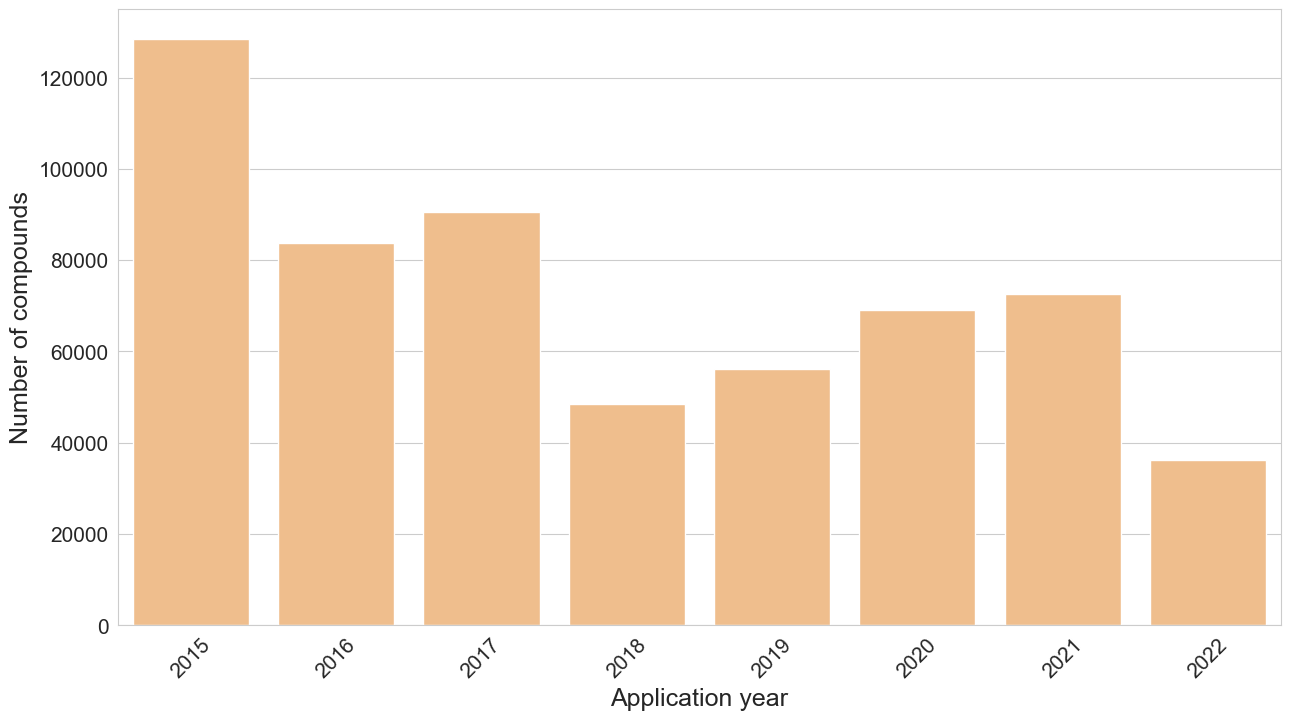

In [16]:
plt.figure(figsize=(15, 8))
sns.countplot(x="year", data=surechembl_only_df, color="#ffbe7d")
plt.xlabel("Application year", fontsize=18)
plt.ylabel("Number of compounds", fontsize=18)
plt.xticks(
    rotation=35,
)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(f"{FIG_DIR}/figure_3b.png", dpi=400)
plt.show()